# Exercise 6: Analysis of real data  (score 30 points)


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn as sns
import os
from common import *
import cv2
#from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.preprocessing import MinMaxScaler


print(f"Root directory: {os.getcwd()}")

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 10,
})

#%matplotlib inline 

Root directory: c:\Users\andre\Dropbox\FYS-STK4155_projects\FYS-STK4155 - Project1\FYS-STK4155-Prj1_report\code


# Global variables

In [2]:
np.random.seed(SEED_VALUE) # Random seed to guarantee reproducibility
# Paths
#INPUT_DATA = "data/input_data/"  # Path for input data
#REPORT_DATA = "data/report_data/" # Path for data ment for the report
#REPORT_FIGURES = "figures/" # Path for figures ment for the report
# Setting for range of degrees
#from_degree = 0
#to_degree = 14
#degrees = np.arange(from_degree,to_degree)
#degree = 5
# Setting for logspace range of lambdas 
#from_lambda = -7 #
#to_lambda = 3 #
#nLambdas = 10
#lambdas = np.logspace(from_lambda, to_lambda, nLambdas)
# Rescale settings
rescale_factor = 0.2

# 0. Reading and plotting terrain data

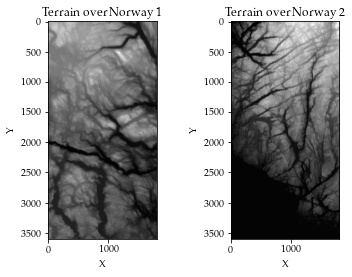

1161


In [3]:
# Load the terrain
terrain1_file = "SRTM_data_Norway_1.tif"
terrain2_file = "SRTM_data_Norway_2.tif"
terrain1 = imread(f'{INPUT_DATA}{terrain1_file}')
terrain2 = imread(f'{INPUT_DATA}{terrain2_file}')

# Plotting terrain
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.title.set_text("Terrain over Norway 1")
ax1.set_xlabel("X"); ax1.set_ylabel("Y")
surf1 = ax1.imshow(terrain1, cmap='gray')
ax2.title.set_text("Terrain over Norway 2")
ax2.set_xlabel("X"); ax2.set_ylabel("Y")
surf2 = ax2.imshow(terrain2, cmap='gray')
plt.savefig(f"{REPORT_FIGURES}terrain_data.pdf")
plt.show()
print(terrain1[0,0])

# 3D plot of the whole Terrain image

In [ ]:
# Make data for terrain1
z1 = np.array(terrain1)
scaler = MinMaxScaler()
scaler.fit(z1)
z1_scaled = scaler.transform(z1)
#y1 = np.linspace(0,1,z1.shape[0])
#x1 = np.linspace(0,1,z1.shape[1])
y1 = np.arange(0, z1.shape[0])
x1 = np.arange(0, z1.shape[1])
x1_m, y1_m = np.meshgrid(x1,y1)

# Make data for terrain2
z2 = np.array(terrain2)
scaler = MinMaxScaler()
scaler.fit(z2)
z2_scaled = scaler.transform(z2)
#y2 = np.linspace(0,1,z2.shape[0])
#x2 = np.linspace(0,1,z2.shape[1])
y2 = np.arange(0, z2.shape[0])
x2 = np.arange(0, z2.shape[1])
x2_m, y2_m = np.meshgrid(x2,y2)

#%matplotlib
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1, projection='3d')
ax1.title.set_text("Terrain1 plot")
ax1.set_xlabel("x"); ax1.set_ylabel("y"); ax1.set_zlabel("z")
ax1.plot_surface(x1_m, y1_m, z1, cmap=cm.coolwarm, linewidth = 0, antialiased=False)

ax2 = fig.add_subplot(1,2,2, projection='3d')
ax2.title.set_text("Terrain2 plot")
ax2.set_xlabel("x"); ax2.set_ylabel("y"); ax2.set_zlabel("z")
ax2.plot_surface(x2_m, y2_m, z2, cmap=cm.coolwarm, linewidth = 0, antialiased=False)
plt.show()

# 1. Preprocessing and transformation of terrain data
Least Square regression is not designed to tackle images directly. Thus, we must first transform the terrain data by slicing it into several bits and pieces. 

# Resizeing the terrain image
For computational purpose, we resize the terrain image to have a resonable amount of datapoints for our least sqaure models.

720
360


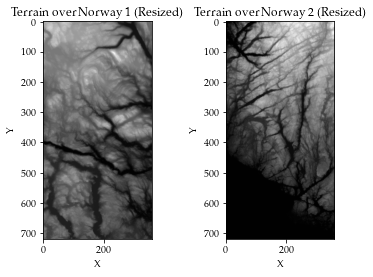

1161


In [4]:
ySize = int(terrain1.shape[0] * rescale_factor); print(ySize)
xSize = int(terrain1.shape[1] * rescale_factor); print(xSize)
terrain1Resized = cv2.resize(terrain1, (xSize, ySize))
terrain2Resized = cv2.resize(terrain2, (xSize, ySize))

# Plotting terrain
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.title.set_text("Terrain over Norway 1 (Resized)")
ax1.set_xlabel("X"); ax1.set_ylabel("Y")
surf1 = ax1.imshow(terrain1Resized, cmap='gray')
ax2.title.set_text("Terrain over Norway 2 (Resized)")
ax2.set_xlabel("X"); ax2.set_ylabel("Y")
surf2 = ax2.imshow(terrain2Resized, cmap='gray')
plt.savefig(f"{REPORT_FIGURES}terrain_data.pdf")
plt.show()
print(terrain1[0,0])

# Creating image patches and Terrain data selection

## Methods

In [5]:
def create_img_patches(img, ySteps, xSteps):
    patches = []
    for y in range(0,img.shape[0], ySteps):
        for x in range(0,img.shape[1], xSteps):
            y_from = y; 
            y_to = y+ySteps; 
            x_from = x; 
            x_to = x+xSteps; 
            img_patch = img[y_from:y_to, x_from:x_to]        
            patches.append(img_patch)

    return patches

def patches_to_img(patches, ySteps, xSteps, nYpatches, nXpatches, plotImage=False):
    img = np.zeros((ySteps*nYpatches, xSteps*nXpatches))
    i = 0
    for y in range(0,img.shape[0], ySteps):
        for x in range(0,img.shape[1], xSteps):
            y_from = y; 
            y_to = y+ySteps; 
            x_from = x; 
            x_to = x+xSteps; 
            img[y_from:y_to, x_from:x_to] = patches[i]         
            i += 1
    
    if plotImage:
        plt.imshow(img, cmap='gray')
        plt.title("Reconstructed img")
        plt.show()
    return img

def plotTerrainPatches(patches, nYpatches, nXpatches, plotTitle="Terrain patches"):
    # Plotting terrain patches
    fig, ax = plt.subplots(nYpatches, nXpatches,figsize=(4,8))
    i=0
    for y in range(nYpatches):
        for x in range(nXpatches):
            ax[y,x].title.set_text(f"Patch{i}")
            ax[y,x].set_xlabel("X"); ax1.set_ylabel("Y")
            ax[y,x].imshow(patches[i], cmap='gray')
            i+=1
    
    fig.suptitle(f"{plotTitle}") # or plt.suptitle('Main title')
    plt.tight_layout()
    plt.show()

def createTerrainData(terrain, includeMeshgrid=True):
    z = np.array(terrain) 
    x = np.arange(0, z.shape[1])
    y = np.arange(0, z.shape[0])
    if includeMeshgrid:
        x, y = np.meshgrid(x,y)
    return x,y,z


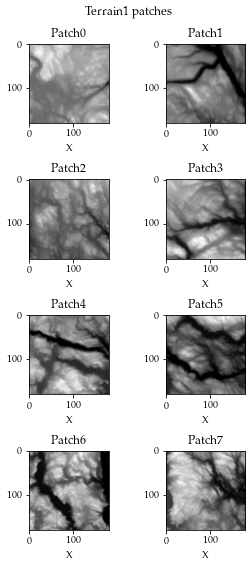

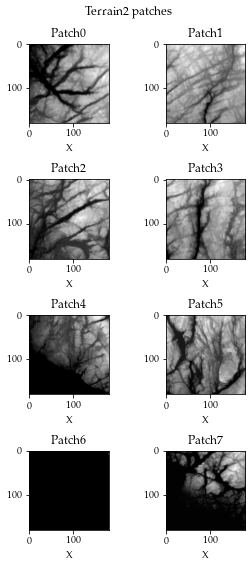

In [6]:
nXpatches = 2; nYpatches=4
ySteps = int(terrain2Resized.shape[0] / nYpatches)
xSteps = int(terrain2Resized.shape[1] / nXpatches)

patches_1 = create_img_patches(terrain1Resized, ySteps, xSteps)
plotTerrainPatches(patches_1, nYpatches, nXpatches, plotTitle="Terrain1 patches")

patches_2 = create_img_patches(terrain2Resized, ySteps, xSteps)
plotTerrainPatches(patches_2, nYpatches, nXpatches, plotTitle="Terrain2 patches")

# test
#img_reconstructed = patches_to_img(patches, ySteps, xSteps, nYpatches, nXpatches, plotImage=True)


# Choosing of terrain patch and data creation
We look at the terrain data patches and choose which to create a fit for

In [7]:
img1 = patches_1[1]
img2 = patches_2[3]
x1, y1, z1 = createTerrainData(img1)
x2, y2, z2 = createTerrainData(img2)

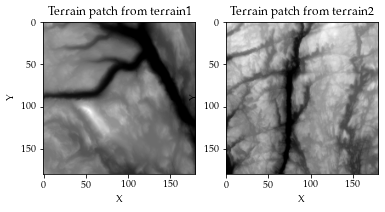

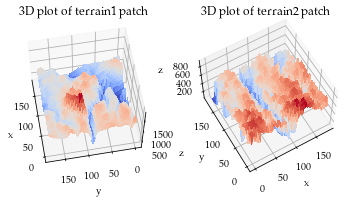

In [8]:
# 2D plot of the terrain patches
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.title.set_text("Terrain patch from terrain1")
ax1.set_xlabel("X"); ax1.set_ylabel("Y")
surf1 = ax1.imshow(img1, cmap='gray')
ax2.title.set_text("Terrain patch from terrain2")
ax2.set_xlabel("X"); ax2.set_ylabel("Y")
surf2 = ax2.imshow(img2, cmap='gray')
plt.show()

# 3D plot of the terrain patches
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1, projection='3d')
ax1.title.set_text("3D plot of terrain1 patch")
ax1.set_xlabel("x"); ax1.set_ylabel("y"); ax1.set_zlabel("z")
ax1.view_init(elev=60., azim=-120.0-70)
ax1.plot_surface(x1, y1, z1, cmap=cm.coolwarm, linewidth = 0, antialiased=False)
ax2 = fig.add_subplot(1,2,2, projection='3d')
ax2.title.set_text("3D plot of terrain2 patch")
ax2.set_xlabel("x"); ax2.set_ylabel("y"); ax2.set_zlabel("z")
ax2.view_init(elev=60., azim=-120.0)
ax2.plot_surface(x2, y2, z2, cmap=cm.coolwarm, linewidth = 0, antialiased=False)
plt.show()

# 2. Base input data for least square regression
We construct the data for least square regression based on preprocessed data. We also set up variables that will be used throughout the exercise.<br>
Terrain patch from terrain 1 is used as input for our models and our tests 

In [9]:
x, y, z = x1, y1, z1

# 3. OLS on data

## Running OLS fit on the data as done in EX1 
Note that we exlude the calculation of CL for betas, since it is emedded within the model itself. See common.py for that code

In [10]:
degrees = 8
z_flat = z.ravel()
z_train_OLS = pd.DataFrame()
z_hat_train_OLS = pd.DataFrame()
z_test_OLS = pd.DataFrame()
z_hat_test_OLS = pd.DataFrame()

OLSrun = []
for degree in range(1, degrees+1):
    print(f"Running OLS fitting on degree{degree}")
    X = create_X(x, y, degree) # Design Matrix
    
    # Scaling data and splitting it into training and test sets
    #X_train, X_test, z_train, z_test = prepare_data(X, z, test_size=0.2, shuffle=True, scale_X=False, scale_t=False)
    X_train, X_test, z_train, z_test = prepare_data(X, z_flat, test_size=0.2, shuffle=True, scale_X=True, scale_t=True, random_state=4155)
    
    # Model construction, fitting, and predictions
    model = OLS(degree=degree) # The model
    z_hat_train = model.fit(X_train, z_train, SVDfit=False) # Fitting the model and predict on training data
    z_hat_test = model.predict(X_test) # predict on test data
    
    # Evaluatation metrics
    MSE_score_train = MSE(z_train, z_hat_train)
    R2_score_train = R2(z_train, z_hat_train)
    MSE_score_test = MSE(z_test, z_hat_test)
    R2_score_test = R2(z_test, z_hat_test)
            
    # Filling up dataframes for train and test evaluation
    z_train_OLS[degree] = z_train.flatten() 
    z_hat_train_OLS[degree] = z_hat_train.flatten()
    z_test_OLS[degree] = z_test.flatten()
    z_hat_test_OLS[degree] = z_hat_test.flatten()

    # Storing data for all degrees
    results = {"X_train":X_train, "X_test":X_test,"z_train":z_train, "z_test":z_test,
               "z_hat_train":z_hat_train, "z_hat_test":z_hat_test, "model":model, "summary":model.summary()}
    OLSrun.append(results)


# MSE calculations for all degrees
mse_scores_train = ((z_train_OLS - z_hat_train_OLS) ** 2).mean()
mse_scores_test = ((z_test_OLS - z_hat_test_OLS) ** 2).mean()
# R2 calculations for all degrees
R2_scores_train = 1 - ((z_train_OLS - z_hat_train_OLS) ** 2).sum() / ((z_train_OLS - z_train_OLS.mean())**2).sum() 
R2_scores_test = 1 - ((z_test_OLS - z_hat_test_OLS) ** 2).sum() / ((z_test_OLS - z_test_OLS.mean())**2).sum()

Running OLS fitting on degree1
Running OLS fitting on degree2
Running OLS fitting on degree3
Running OLS fitting on degree4
Running OLS fitting on degree5
Running OLS fitting on degree6
Running OLS fitting on degree7
Running OLS fitting on degree8


## Plotting performance of OLS for different degrees

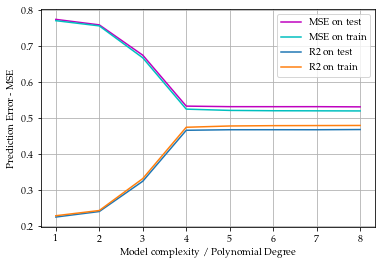

In [11]:
plt.plot(np.arange(1,degrees+1), mse_scores_test,"m", label='MSE on test')
plt.plot(np.arange(1,degrees+1), mse_scores_train,"c", label='MSE on train')

plt.plot(np.arange(1,degrees+1), R2_scores_test, label='R2 on test')
plt.plot(np.arange(1,degrees+1), R2_scores_train, label='R2 on train')

plt.xlabel("Model complexity / Polynomial Degree")
plt.ylabel("Prediction Error - MSE")

plt.grid(True)
plt.legend()
#plt.savefig(f"{REPORT_FIGURES}franke_function_OLS_evaluate_fit.pdf")
plt.show()

## Looking at $\beta$ values from degree 4

In [12]:
OLSrunOptimal = OLSrun[3]
OLS_summary = OLSrunOptimal["summary"]
display(OLS_summary)

,degree,coeff name,coeff value,Std Error,CI lower,CI_upper
0,4.0,b_0,0.0,0.0,0.0,0.0
1,4.0,b_1,-1.8848,0.1236,-2.127,-1.6427
2,4.0,b_2,-2.1686,0.1232,-2.4099,-1.9272
3,4.0,b_3,-4.4353,0.4169,-5.2524,-3.6182
4,4.0,b_4,10.7119,0.2394,10.2428,11.181
5,4.0,b_5,1.5707,0.416,0.7553,2.3862
6,4.0,b_6,8.4778,0.5447,7.4102,9.5453
7,4.0,b_7,-6.4185,0.2898,-6.9864,-5.8505
8,4.0,b_8,-8.9563,0.2887,-9.5222,-8.3904
9,4.0,b_9,1.6566,0.5441,0.5902,2.723


## Plotting the fitted terrain image using the most optimal degree

In [13]:
OLS_X_test = OLSrunOptimal["X_test"]
OLS_y_test = OLSrunOptimal["z_test"]


### Comments on the OLS fit to terrain data:
We scale the data since x, y, z is they are not between 0 to 1. Degree of 4 seems to yeild the best performance when fitting to the choosen terrain data.

# Tests of dimensions image reduction and patches

In [14]:
i = 1
value = 720
while True:
    i += 1
    if((value % i)==0):
        print(f"value:{value / i} at i:{i}")
    if(i>=value):
        break

value:360.0 at i:2
value:240.0 at i:3
value:180.0 at i:4
value:144.0 at i:5
value:120.0 at i:6
value:90.0 at i:8
value:80.0 at i:9
value:72.0 at i:10
value:60.0 at i:12
value:48.0 at i:15
value:45.0 at i:16
value:40.0 at i:18
value:36.0 at i:20
value:30.0 at i:24
value:24.0 at i:30
value:20.0 at i:36
value:18.0 at i:40
value:16.0 at i:45
value:15.0 at i:48
value:12.0 at i:60
value:10.0 at i:72
value:9.0 at i:80
value:8.0 at i:90
value:6.0 at i:120
value:5.0 at i:144
value:4.0 at i:180
value:3.0 at i:240
value:2.0 at i:360
value:1.0 at i:720


In [15]:
i = 1
value = 360
while True:
    i += 1
    if((value % i)==0):
        print(f"value:{value / i} at i:{i}")
    if(i>=value):
        break

value:180.0 at i:2
value:120.0 at i:3
value:90.0 at i:4
value:72.0 at i:5
value:60.0 at i:6
value:45.0 at i:8
value:40.0 at i:9
value:36.0 at i:10
value:30.0 at i:12
value:24.0 at i:15
value:20.0 at i:18
value:18.0 at i:20
value:15.0 at i:24
value:12.0 at i:30
value:10.0 at i:36
value:9.0 at i:40
value:8.0 at i:45
value:6.0 at i:60
value:5.0 at i:72
value:4.0 at i:90
value:3.0 at i:120
value:2.0 at i:180
value:1.0 at i:360
